<a href="https://colab.research.google.com/github/Chaza-dally/ai4eo-project-3/blob/main/ai4eo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

input = "/content/images/input"
output = "/content/images/output"

os.makedirs(output, exist_ok=True)  # Create output folder if it doesn't exist

print("Images found:", os.listdir(input))


Images found: []


In [ ]:
script_code = """import cv2
import numpy as np
import os
import argparse
from pathlib import Path
from typing import List


def equalize_size(img1, img2):
    if np.prod(img1.shape) < np.prod(img2.shape):
        shape = img1.shape
        img2 = cv2.resize(img2, (shape[1], shape[0]))
    else:
        shape = img2.shape
        img1 = cv2.resize(img1, (shape[1], shape[0]))
    return img1, img2

def create_smooth_mask(shape, blend_width, direction='horizontal'):
    height, width = shape[:2]
    mask = np.zeros((height, width), dtype=np.float32)

    if direction == 'horizontal':
        mask[:, :blend_width] = np.linspace(0, 1, blend_width)
        mask[:, -blend_width:] = np.linspace(1, 0, blend_width)
        mask[:, blend_width:-blend_width] = 1
    else:
        mask[:blend_width, :] = np.linspace(0, 1, blend_width)[:, None]
        mask[-blend_width:, :] = np.linspace(1, 0, blend_width)[:, None]
        mask[blend_width:-blend_width, :] = 1

    return mask

def create_blend_mask(img_shape: tuple, blend_width: int = 100, direction: str = 'horizontal') -> np.ndarray:
    height, width = img_shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    if direction == 'horizontal':
        mask[:, :blend_width] = np.linspace(0, 255, blend_width, dtype=np.uint8)
        mask[:, -blend_width:] = np.linspace(255, 0, blend_width, dtype=np.uint8)
    else:
        mask[:blend_width, :] = np.linspace(0, 255, blend_width, dtype=np.uint8)[:, None]
        mask[-blend_width:, :] = np.linspace(255, 0, blend_width, dtype=np.uint8)[:, None]

    return mask

def match_histograms(source: np.ndarray, target: np.ndarray) -> np.ndarray:
    source_lab = cv2.cvtColor(source, cv2.COLOR_BGR2LAB)
    target_lab = cv2.cvtColor(target, cv2.COLOR_BGR2LAB)

    for i in range(3):
        src_hist, _ = np.histogram(source_lab[:, :, i].ravel(), bins=256, range=(0, 256))
        tgt_hist, _ = np.histogram(target_lab[:, :, i].ravel(), bins=256, range=(0, 256))

        src_cdf = np.cumsum(src_hist).astype(float)
        tgt_cdf = np.cumsum(tgt_hist).astype(float)
        src_cdf /= src_cdf[-1]
        tgt_cdf /= tgt_cdf[-1]

        mapping = np.interp(src_cdf, tgt_cdf, np.arange(256))
        source_lab[:, :, i] = cv2.LUT(source_lab[:, :, i], mapping.astype(np.uint8))

    return cv2.cvtColor(source_lab, cv2.COLOR_LAB2BGR)

def pyramid_blend(img1: np.ndarray, img2: np.ndarray, mask: np.ndarray, levels: int = 5) -> np.ndarray:

    # Ensure all inputs match dimensions
    h, w = mask.shape[:2]
    img1 = cv2.resize(img1, (w, h))
    img2 = cv2.resize(img2, (w, h))

    # Convert to float32 for blending
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    mask = mask.astype(np.float32) / 255.0  # Normalize to [0,1]

    # Expand mask to 3 channels if needed
    if len(mask.shape) == 2:
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

    # Build Gaussian pyramids
    gp1 = [img1]
    gp2 = [img2]
    gpM = [mask]

    for _ in range(levels):
        gp1.append(cv2.pyrDown(gp1[-1]))
        gp2.append(cv2.pyrDown(gp2[-1]))
        gpM.append(cv2.pyrDown(gpM[-1]))

    # Build Laplacian pyramids with exact size matching
    lp1 = [gp1[-1]]
    lp2 = [gp2[-1]]

    for i in range(levels, 0, -1):
        size = (gp1[i-1].shape[1], gp1[i-1].shape[0])

        # Safe upsampling with exact size matching
        up1 = cv2.pyrUp(gp1[i], dstsize=size)
        up2 = cv2.pyrUp(gp2[i], dstsize=size)

        lp1.append(gp1[i-1] - up1)
        lp2.append(gp2[i-1] - up2)

    # Blend pyramids
    LS = []
    for la, lb, gm in zip(lp1, lp2, reversed(gpM)):
        # Resize mask to match current pyramid level
        gm_resized = cv2.resize(gm, (la.shape[1], la.shape[0]))
        LS.append(la * (1.0 - gm_resized) + lb * gm_resized)

    # Reconstruct
    blended = LS[0]
    for i in range(1, levels+1):
        blended = cv2.pyrUp(blended, dstsize=(LS[i].shape[1], LS[i].shape[0]))
        blended += LS[i]

    # Clip and convert back to uint8
    return np.clip(blended, 0, 255).astype(np.uint8)

def load_images(image_paths: List[str]) -> List[np.ndarray]:
    images = [cv2.imread(str(Path(p))) for p in image_paths]
    if any(img is None for img in images):
        raise ValueError("One or more images could not be loaded.")

    base_shape = images[0].shape[:2]
    return [cv2.resize(img, (base_shape[1], base_shape[0])) for img in images]

def blend_images(images, blend_width=100, direction='horizontal'):

    composite = images[0].copy()

    for i in range(1, len(images)):
        mask = create_smooth_mask(composite.shape, blend_width, direction)
        adjusted_img = histogram_match(images[i], composite)
        composite = pyramid_blend(composite, adjusted_img, mask)

    return composite

def blend_images_sequential(images: List[np.ndarray], blend_width: int, direction: str) -> np.ndarray:
    composite = images[0].copy()
    for i in range(1, len(images)):
        mask = create_blend_mask(composite.shape, blend_width, direction)
        matched_img = match_histograms(images[i], composite)
        composite = pyramid_blend(composite, matched_img, mask)


    return composite


def main():
    parser = argparse.ArgumentParser(description='Blend satellite images with feathering and color adjustment.')
    parser.add_argument('--input', type=str, required=True, help='Input directory containing images')
    parser.add_argument('--output', type=str, required=True, help='Output file path')
    parser.add_argument('--blend_width', type=int, default=100, help='Width of the blending mask')
    parser.add_argument('--direction', type=str, choices=['horizontal', 'vertical'], default='horizontal', help='Blending direction')
    args = parser.parse_args()

    image_paths = sorted([os.path.join(args.input, f) for f in os.listdir(args.input) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
    if len(image_paths) < 2:
        raise ValueError("At least 2 images are required.")

    images = load_images(image_paths)
    final_composite = blend_images_sequential(images, args.blend_width, args.direction)
    cv2.imwrite(args.output, final_composite)
    print(f"Saved composite image to {args.output}")

if __name__ == "__main__":
    main()
"""

with open("/content/script.py", "w") as f:
    f.write(script_code)

print("✅ Script saved as script.py")








✅ Script saved as script.py


In [ ]:
!pip install opencv-python-headless numpy

In [ ]:
!python /content/script.py --input "/content/images/input" --output "/content/images/output/composite.jpg" --blend_width 150 --direction horizontal


Saved composite image to /content/images/output/composite.jpg


Loaded: sat_2.png
Loaded: sat_1.png

Displaying results:


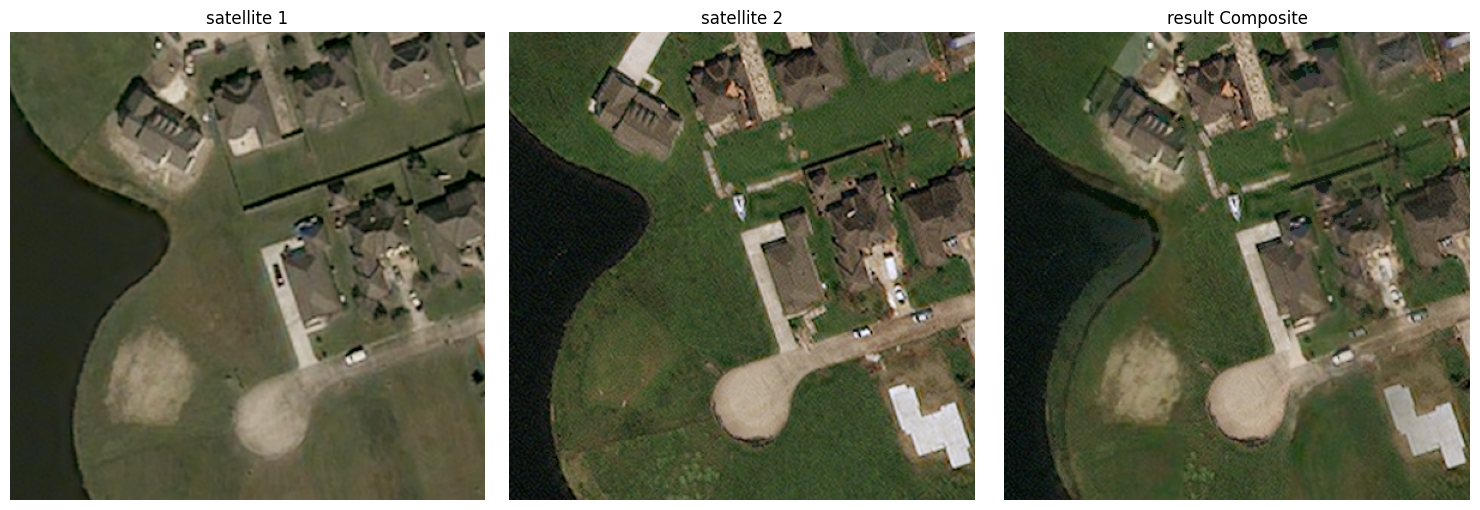

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from pathlib import Path

def visualize_comparison(original1, original2, result,
                        titles=('Image 1', 'Image 2', 'Result')):
    """Display three images side by side"""
    # Convert BGR to RGB for matplotlib
    img1_rgb = cv2.cvtColor(original1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(original2, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img1_rgb)
    plt.title(titles[0])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img2_rgb)
    plt.title(titles[1])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_rgb)
    plt.title(titles[2])
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def main_processing():
    # Set paths
    input_dir = '/content/images/input'
    output_dir = '/content/images/output'
    output_path = str(Path(output_dir) / 'composite.jpg')

    # Create output directory if needed
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Load input images
    input_images = []
    valid_extensions = ('.jpg', '.jpeg', '.png')

    for img_path in Path(input_dir).iterdir():
        if img_path.suffix.lower() in valid_extensions:
            img = cv2.imread(str(img_path))
            if img is not None:
                input_images.append(img)
                print(f"Loaded: {img_path.name}")

    if len(input_images) < 2:
        print("Error: Need at least 2 valid images in input directory")
        return



    # Load the saved composite to verify
    saved_composite = cv2.imread(output_path)
    if saved_composite is None:
        print("Error: Could not verify saved composite image")
        return

    def auto_color_balance(img, clip_hist_percent=1):

    # Convert to LAB color space
      lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Split channels
      l, a, b = cv2.split(lab)

    # CLAHE on L-channel (lightness)
      clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
      l = clahe.apply(l)

    # Merge channels and convert back
      balanced = cv2.merge((l,a,b))
      return cv2.cvtColor(balanced, cv2.COLOR_LAB2BGR)


    enhanced = auto_color_balance(saved_composite)

    # Display results
    print("\nDisplaying results:")
    visualize_comparison(input_images[0], input_images[1], saved_composite,
                       titles=('satellite 1', 'satellite 2', 'result Composite'))



if __name__ == "__main__":
    main_processing()

In [ ]:
def calculate_edge_smoothness(img):
    # Check if the image was loaded successfully
    if img is None:
        print("Error: Image not loaded correctly.")  # Print a message to the user
        return -1  # or any other value indicating failure

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return laplacian.var()
sat1 = cv2.imread('/content/images/input/sat1.jpg')
sat2 = cv2.imread('/content/images/input/sat2.jpg')
composite = cv2.imread('/content/images/output/composite.jpg')

# Check if images were loaded
if sat1 is not None and composite is not None:  # Add check for sat1
    original_edge = calculate_edge_smoothness(sat1)
    blended_edge = calculate_edge_smoothness(composite)

    # Print the results only if the images were loaded
    if original_edge != -1 and blended_edge != -1:  # Add check for failure
        print(f"Edge smoothness improvement: {(blended_edge/original_edge-1)*100:.1f}%")
else:
    print("Error: One or more images could not be loaded.")

Error: One or more images could not be loaded.
